# Screening Task 1 for QOSF Mentorship

## Problem statement

1. Problem statement (Add images)

2. An overview of my approach. 3 different methods. Statevector_simulator, qasm_simulator, pennylane

3. Show the approaches and add proper documentation to the functions defined.

4. Explain differences of the approaches taken.

5. Conclusions, further work and things to try.

The idea of task 1 is to implement the following variational circuit that prepares a 4 qubit state $| \Psi(\theta)\rangle$

<img src="images/circuit1.jpg">

Here, we call as a layer to the combination of an odd block (yellow) and an even block (green). The number of layers denoted by $L$ is an hyperparameter of the variational circuit.

Specifically, each block is defined as follows:

                                             Odd block
<img src="images/odd_block.jpg" style="width:350px;height:150px"/>

                                             Even block
<img src="images/even_block.jpg" style="width:500px;height:150px"/>

Where the double qubits gates are $CZ$ gates and a layer of the variational circuit is composed by 8 parameters denoted by $\theta_{i, n}$ (4 parameters per block).

The idea is to report with a plot, as a function of the number of layers, the minimum distance

$\varepsilon = min_{\theta}\left \| \Psi(\theta) - \phi \rangle \right \|$

Where $|\phi\rangle$ is a randomly generated vector of 4 qubits, i.e. 16 dimensions, and $\left \| v \rangle \right \| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$. The right set of parameters $\theta_{i, n}$ can be found via any method of choice.

You can go to the source document where all the screening tasks are explained and discussed <a href="https://docs.google.com/document/d/1Ow3v8Y4rYBdgxXNxKV9ZUAM4bwL6211U6DWCcByZ4A4/edit" target="_blank">here</a>.

## Overview of the approach

In the following we will show

1. Generate a proper random quantum state and its probability vector.


2. Building the variational quantum circuit using `Qiskit`.


3. Optimization of the variational circuit in `Qiskit Aer StatevectorSimulator` backend `COBYLA` optimizer.


4. Optimization of the variational circuit in `Qiskit Aer QasmSimulator` backend `COBYLA` optimizer.


5. Building the variation quantum circuit using `Pennylane`.


6. Optimizating Quantum Fidelity in `Pennylane` using `GradientDescentOptimizer` optimizer.


<a href="https://qiskit.org/documentation/tutorials/simulators/1_aer_provider.html" target="_blank">Qiskit Aer Simulators.</a>

$\mathrm{Re}\left \{ \langle \Psi(\theta) - \phi| \Psi(\theta) - \phi \rangle \right \} = 1$

### Imports

In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

In [2]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int, amplitude_type: str = 'complex') -> np.array:
    """Creates a normalized random real or complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
        amplitude_type (str): string indicating if you want to create a
            vector with 'complex' or 'real' number amplitudes.
            
    Returns:
        (np.array): normalized real or complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    if amplitude_type == 'complex':
        Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #generate an unnormalized real vector of dimension = dim
    elif amplitude_type == 'real':
        Z = np.random.random(dim)
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of the respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))

In [3]:
#two qubits -> a complex vector of dimension 4
n_qubits = 1
dim = 2**(n_qubits)
psi = random_quantum_state(dim)
psi

tensor([0.05423711+0.53754663j, 0.57163759+0.61752119j], requires_grad=True)

In [4]:
get_probabilities(psi)

tensor([0.29189805, 0.70810195], requires_grad=True)

## Building the variational quantum circuit in Qiskit

In [5]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    """Build the variational quantum circuit with a defined
    number of layers.
    
    Arguments:
        number_layers (int): number of layers that we want.
        
        params (np.array): np.array of shape (8*number_layers,)
            with the set of angles for the complete variational
            circuit.
            
    Returns:
        (QuantumCircuit): QuantumCircuit object from Qisikit.
            This is our variational quantum circuit.
    """
    
    #number of parameters depending on the number of layers-
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc

def layer(qc: QuantumCircuit, params: np.array) -> None:
    """A layer is defined by a combination of an
    odd block and an even block. First we apply the odd 
    block to the Quantum Circuit and then the even block.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the two blocks.
        
        params (np.array): np.array of shape (8,) with the angles
            for each block.
    
    Returns:
        (None)
    """
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RX to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RX gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    """Apply the proper set of RZ and CZ to a Quantum Circuit
    defined by the problem statement.
    
    Arguments:
        qc (QuantumCircuit): QuantumCircuit object from Qiskit
            in which we are going to apply the set of gates.
        
        params (np.array): np.array of shape (4,) with the angles
            for each RZ gate.
    
    Returns:
        (None)
    """
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [6]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

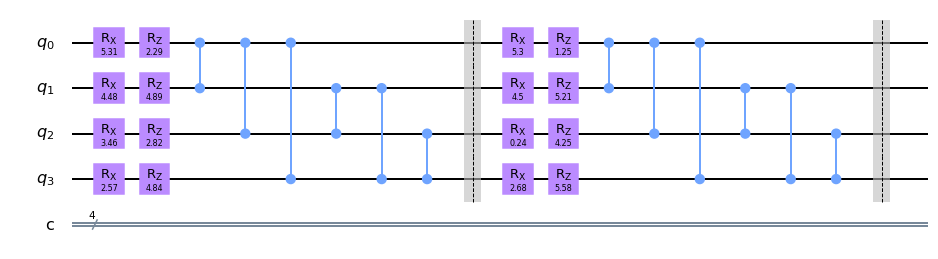

In [7]:
qc.draw(output='mpl')

## Optimization using `Qiskit Aer StatevectorSimulator`

In [8]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[-0.04328963-0.08011919j -0.00587885+0.11863621j  0.06673315-0.05801548j
 -0.02982162-0.02536842j  0.11004985-0.335454j    0.18008253-0.54307562j
  0.39811396+0.44593372j -0.15844432+0.09449667j -0.01340246+0.00631027j
 -0.0022041 +0.01178746j -0.05347979-0.00753116j  0.00125166-0.01593382j
  0.00687271-0.10518746j  0.00392231+0.02604634j -0.02912165+0.31538253j
  0.0958723 -0.00348292j]


In [9]:
def norm_vector_difference(params):
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.square(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

## Random target quantum state initialization.

In [10]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

## Optimization routine with different number of layers

In [11]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
params_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Vector:", target_vector)
        print("Obtained Vector:", final_vector)
        print("Norm difference:", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Vector: [0.06916016+0.01945996j 0.22513991+0.29029778j 0.10527007+0.28063279j
 0.02363482+0.09703263j 0.06651971+0.12637834j 0.13976885+0.21283402j
 0.11838043+0.25013187j 0.20246457+0.08174562j 0.11391824+0.17244751j
 0.04683416+0.20723894j 0.04325343+0.14760652j 0.23445873+0.2059082j
 0.28175274+0.03365538j 0.2650644 +0.15834698j 0.19489927+0.0444617j
 0.26289172+0.23827174j]
Obtained Vector: [-0.13793619+0.j          0.07696739+0.20074076j  0.06220115+0.17555207j
 -0.22077598+0.18847911j  0.13415064+0.08049262j -0.04228714+0.24014589j
 -0.04194927+0.20703165j  0.32470388-0.0544727j   0.08416953+0.13807834j
 -0.15398165+0.19953998j -0.13777745+0.16938823j  0.32339223+0.10599235j
  0.00128399+0.18340599j  0.26619723-0.10420782j  0.2328427 -0.08433951j
  0.25266518+0.29179891j]
Norm difference: 0.735176801450309
Parameters Found: [4.28247704 4.41652596 1.69638673 4.55404124 2.77546334 2.8010768
 5.25282075 2.59416017]

Number of layers: 4
Target Vector: [0.06

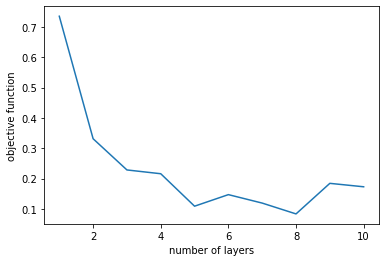

In [12]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

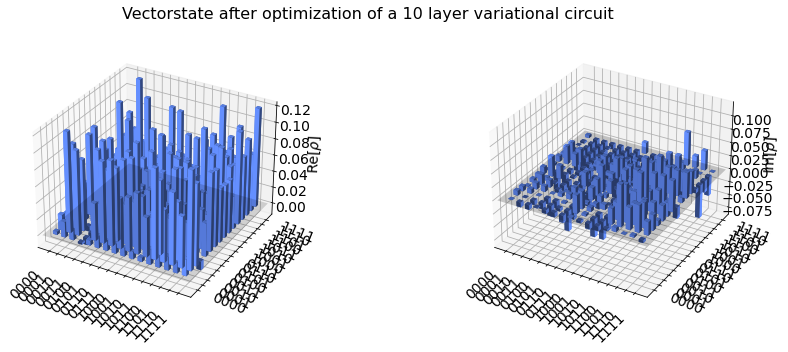

In [13]:
qc = build_variational_circuit(10, params_list[9])

statevector = execute(qc, backend).result().get_statevector(qc, decimals = 3)

plot_state_city(statevector, title='Vectorstate after optimization of a 10 layer variational circuit')

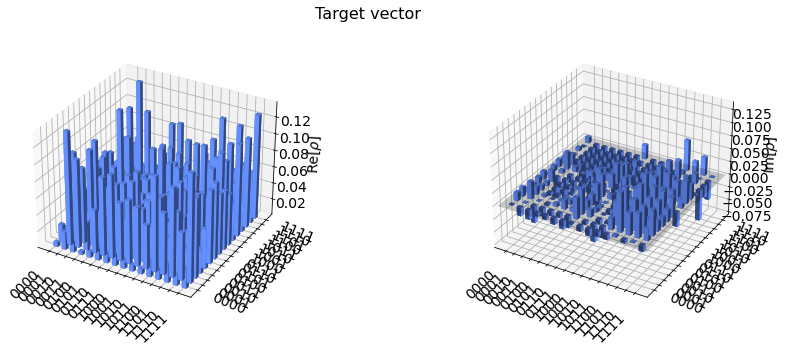

In [14]:
plot_state_city(target_vector, title='Target vector')

In [15]:
backend = Aer.get_backend('statevector_simulator')
n_layers = 10
norm_vector_difference(params_list[9])

0.17301307500715715

In [16]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
params_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    params_list.append(ret[0])
    
    if n_layers in range(1,11,3):
        print("Number of layers:", n_layers)
        print("Target Distribution:", target_distr)
        print("Obtained Distribution:", output_distr)
        print("Output Error (square-error):", ret[1])
        print("Parameters Found:", ret[0])
        print('')

Number of layers: 1
Target Distribution: [0.00516182 0.13496078 0.08983655 0.00997394 0.02039636 0.06483365
 0.07657988 0.04767425 0.04271551 0.04514141 0.02365854 0.09736908
 0.08051729 0.0953329  0.03996257 0.12588548]
Obtained Distribution: [0.0388 0.0513 0.0334 0.0485 0.0509 0.0712 0.0504 0.0659 0.0549 0.07
 0.0491 0.0696 0.0736 0.0991 0.076  0.0973]
Output Error (square-error): 0.019376594157813662
Parameters Found: [4.56431954 4.73507668 1.73257237 4.52908417 5.23951813 5.88392655
 0.60966162 4.63684393]

Number of layers: 4
Target Distribution: [0.00516182 0.13496078 0.08983655 0.00997394 0.02039636 0.06483365
 0.07657988 0.04767425 0.04271551 0.04514141 0.02365854 0.09736908
 0.08051729 0.0953329  0.03996257 0.12588548]
Obtained Distribution: [0.0292 0.1164 0.0893 0.0154 0.02   0.0702 0.0371 0.0654 0.042  0.0461
 0.0615 0.1    0.0713 0.0704 0.0225 0.1432]
Output Error (square-error): 0.006438601999235078
Parameters Found: [ 1.67178994  3.26431151  5.56500318  4.01099109  4.1452

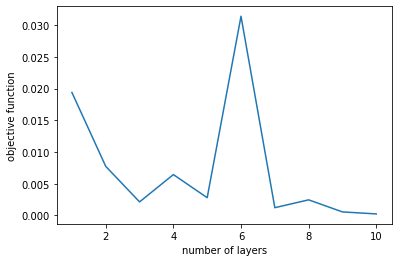

In [17]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

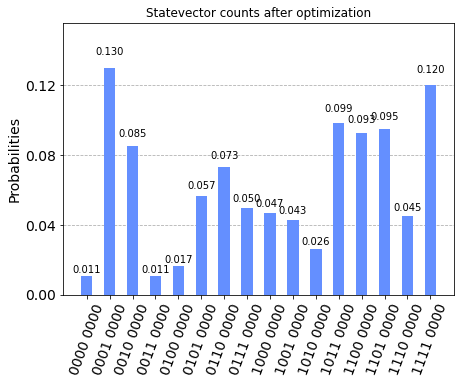

In [18]:
qc = build_variational_circuit(10, params_list[9])
qc.measure_all()
result = execute(qc, backend).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='Statevector counts after optimization')

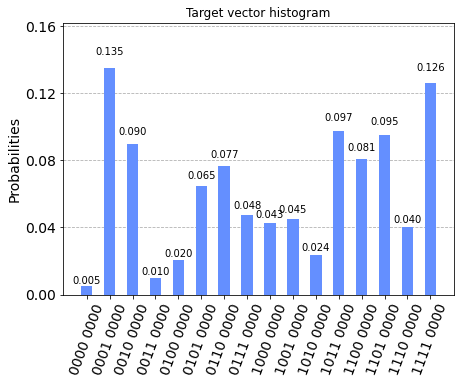

In [19]:
counts_target = {list(counts.keys())[i]: target_distr[i]*NUM_SHOTS for i in range(target_distr.shape[0])}
plot_histogram(counts_target, title='Target vector histogram')

In [20]:
backend = Aer.get_backend('statevector_simulator')
n_layers = 10
norm_vector_difference(params_list[9])

1.4992470281204229

## Optimize the variational circuit using Pennylane

In [21]:
dev = qml.device('default.qubit', wires = 4)

In [22]:
target_vector_reshape = target_vector.reshape((16,1))
density_matrix = target_vector_reshape @ np.transpose(np.conjugate(target_vector_reshape))
print(density_matrix.shape)

(16, 16)


In [23]:
def layer_pennylane(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block_pennylane(params[:int(n_parameters/2)])
        even_block_pennylane(params[int(n_parameters/2):])

def odd_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block_pennylane(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [24]:
@qml.qnode(dev)
def var_circuit(params):

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer_pennylane(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [25]:
def cost(x):
    
    return (1.0 - var_circuit(x))

In [26]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

cost(params)

0.9564516795646147

In [27]:
init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

In [28]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [29]:
cost_list = []
params_list = []
for number_layers in range(1,11):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))
    cost_list.append(cost(params))
    params_list.append(params)

0.8645970949488746
0.07263247046489674
0.08465247123845276
0.05320358100097622
0.0012127989650445592
0.003962964941141345
0.0024474846164295183
0.00015006206290835156
0.00030846458824562717
1.0633652181013531e-08


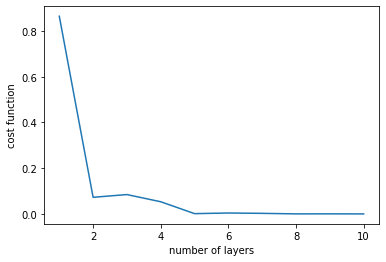

In [30]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("cost function")
plt.show()

In [31]:
backend = Aer.get_backend('statevector_simulator')
n_layers = 10
norm_vector_difference(params_list[9])

1.374810200158699

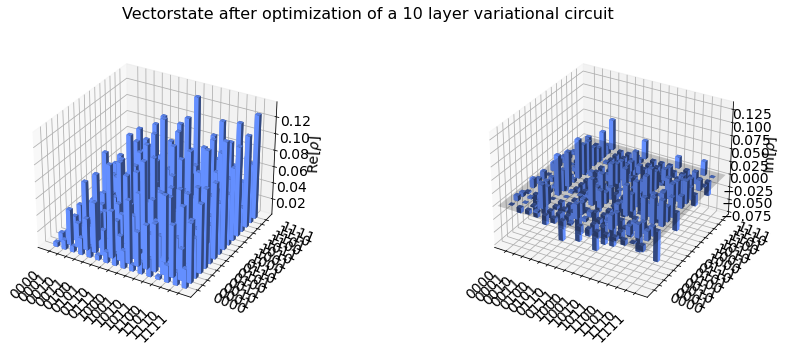

In [32]:
qc = build_variational_circuit(n_layers, params_list[9])

statevector = execute(qc, backend).result().get_statevector(qc, decimals = 3)

plot_state_city(statevector, title='Vectorstate after optimization of a 10 layer variational circuit')

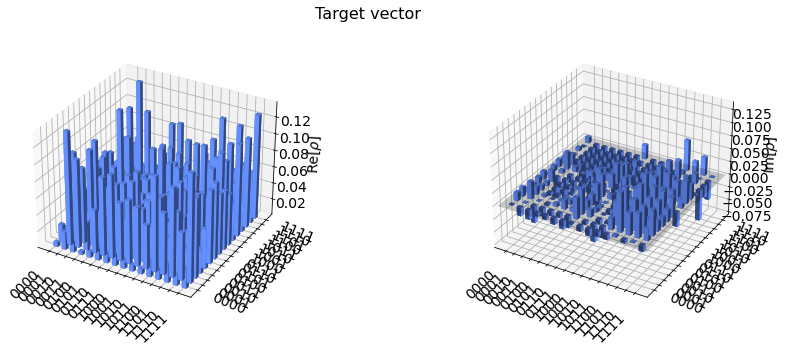

In [33]:
plot_state_city(target_vector, title='Target vector')

## Conclusions